# Revisiting bit collisions in Morgan fingerprints with a larger dataset

This is an updated and revised version of an [old post](http://rdkit.blogspot.com/2016/02/colliding-bits-iii.html)

I looked at the number of collisions in Morgan fingerprints in an [earlier post](http://rdkit.blogspot.ch/2014/02/colliding-bits.html). The topic came up again in discussions about the recent post on [Morgan fingerprint stats](http://rdkit.blogspot.ch/2016/02/morgan-fingerprint-bit-statistics.html), which used a much larger data set. 

Here we repeat earlier collision analysis, usting the larger dataset. I will look at fingerprints with different radii -- 1, 2, and 3 -- folded to a set of different sizes -- 1K, 2K, 4K, 8K, 16K.

TL;DR version: The conclusions match what we observed before, there are a fair number of collisions at fingerprint sizes below 4K. As expected, higher radii have more collisions. 

In [1]:
from rdkit import Chem,DataStructs
import time,random,gzip,pickle,copy
import numpy as np
from collections import defaultdict
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
%pylab inline
plt.style.use('tableau-colorblind10')
print(rdkit.__version__)
import time
print(time.asctime())

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
2022.09.1
Sat Jan  7 05:31:07 2023


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


For test data I'll use the 4 million random compounds from PubChem with <=50 heavy atoms. I constructed the set of compounds by downloading the [full pubchem compound set](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-SMILES.gz) (on 8 Jan, 2023), and picking 10 million random lines using an [awk script](https://stackoverflow.com/a/692401).

In [91]:
filen='/localhome/glandrum/Datasets/PubChem/pubchem_compound_random_10000000.txt.gz'

Loop over the molecules and build fingerprints of multiple radii and folded lengths.

In [94]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import copy
history={} # we will use this to see how quickly the results converge
counts=defaultdict(lambda:defaultdict(int))
t1 = time.time()
i = 0
with gzip.open(filen,'rb') as inf:
    for inl in inf:
        try:
            nm,smi = inl.strip().split()
        except:
            break
        m = Chem.MolFromSmiles(smi)
        if m is None or m.GetNumHeavyAtoms()>50:
            continue
        i+=1
        for v in 1,2,3:
            fpg = rdFingerprintGenerator.GetMorganGenerator(radius=v)
            onbits=len(fpg.GetSparseFingerprint(m).GetOnBits())
            counts[(v,-1)][onbits]+=1
            for l in 64,128,256,512,1024,2048,4096,8192,16384:
                fpg = rdFingerprintGenerator.GetMorganGenerator(radius=v,fpSize=l)
                dbits = onbits-fpg.GetFingerprint(m).GetNumOnBits()
                counts[(v,l)][dbits]+=1
        if not i%50000:
            t2 = time.time()
            print(f"Done {i} in {t2-t1:.2f} sec")
        if not i%100000:
            history[i] = copy.deepcopy(counts)
        if i>=4000000:
            break

Done 50000 in 57.94 sec
Done 100000 in 125.87 sec
Done 150000 in 205.79 sec
Done 200000 in 278.77 sec
Done 250000 in 353.97 sec
Done 300000 in 435.63 sec
Done 350000 in 519.25 sec
Done 400000 in 600.79 sec
Done 450000 in 679.81 sec
Done 500000 in 760.31 sec
Done 550000 in 830.27 sec
Done 600000 in 900.44 sec
Done 650000 in 970.40 sec
Done 700000 in 1040.55 sec
Done 750000 in 1121.73 sec
Done 800000 in 1196.58 sec
Done 850000 in 1268.15 sec
Done 900000 in 1343.85 sec
Done 950000 in 1395.36 sec
Done 1000000 in 1457.15 sec
Done 1050000 in 1542.61 sec
Done 1100000 in 1620.64 sec
Done 1150000 in 1695.22 sec
Done 1200000 in 1773.86 sec
Done 1250000 in 1854.29 sec
Done 1300000 in 1925.72 sec
Done 1350000 in 1995.17 sec
Done 1400000 in 2062.94 sec
Done 1450000 in 2133.66 sec
Done 1500000 in 2206.72 sec
Done 1550000 in 2290.43 sec
Done 1600000 in 2375.93 sec
Done 1650000 in 2457.73 sec
Done 1700000 in 2536.96 sec
Done 1750000 in 2605.62 sec
Done 1800000 in 2680.01 sec
Done 1850000 in 2751.66 se

In [95]:
pickle.dump(dict(counts),gzip.open('../data/fp_collision_counts.pkl.gz','wb+'))

In [96]:
for k,d in history.items():
    history[k] = dict(d)
pickle.dump(dict(history),gzip.open('../data/fp_collision_counts.history.pkl.gz','wb+'))

In [62]:
with gzip.open('../data/fp_collision_counts.pkl.gz','rb') as inf:
    counts = pickle.load(inf)
with gzip.open('../data/fp_collision_counts.history.pkl.gz','rb') as inf:
    history = pickle.load(inf)

Now plot histograms of the numbers of collisions along with the distributions of the number of bits set in the non-folded FPs

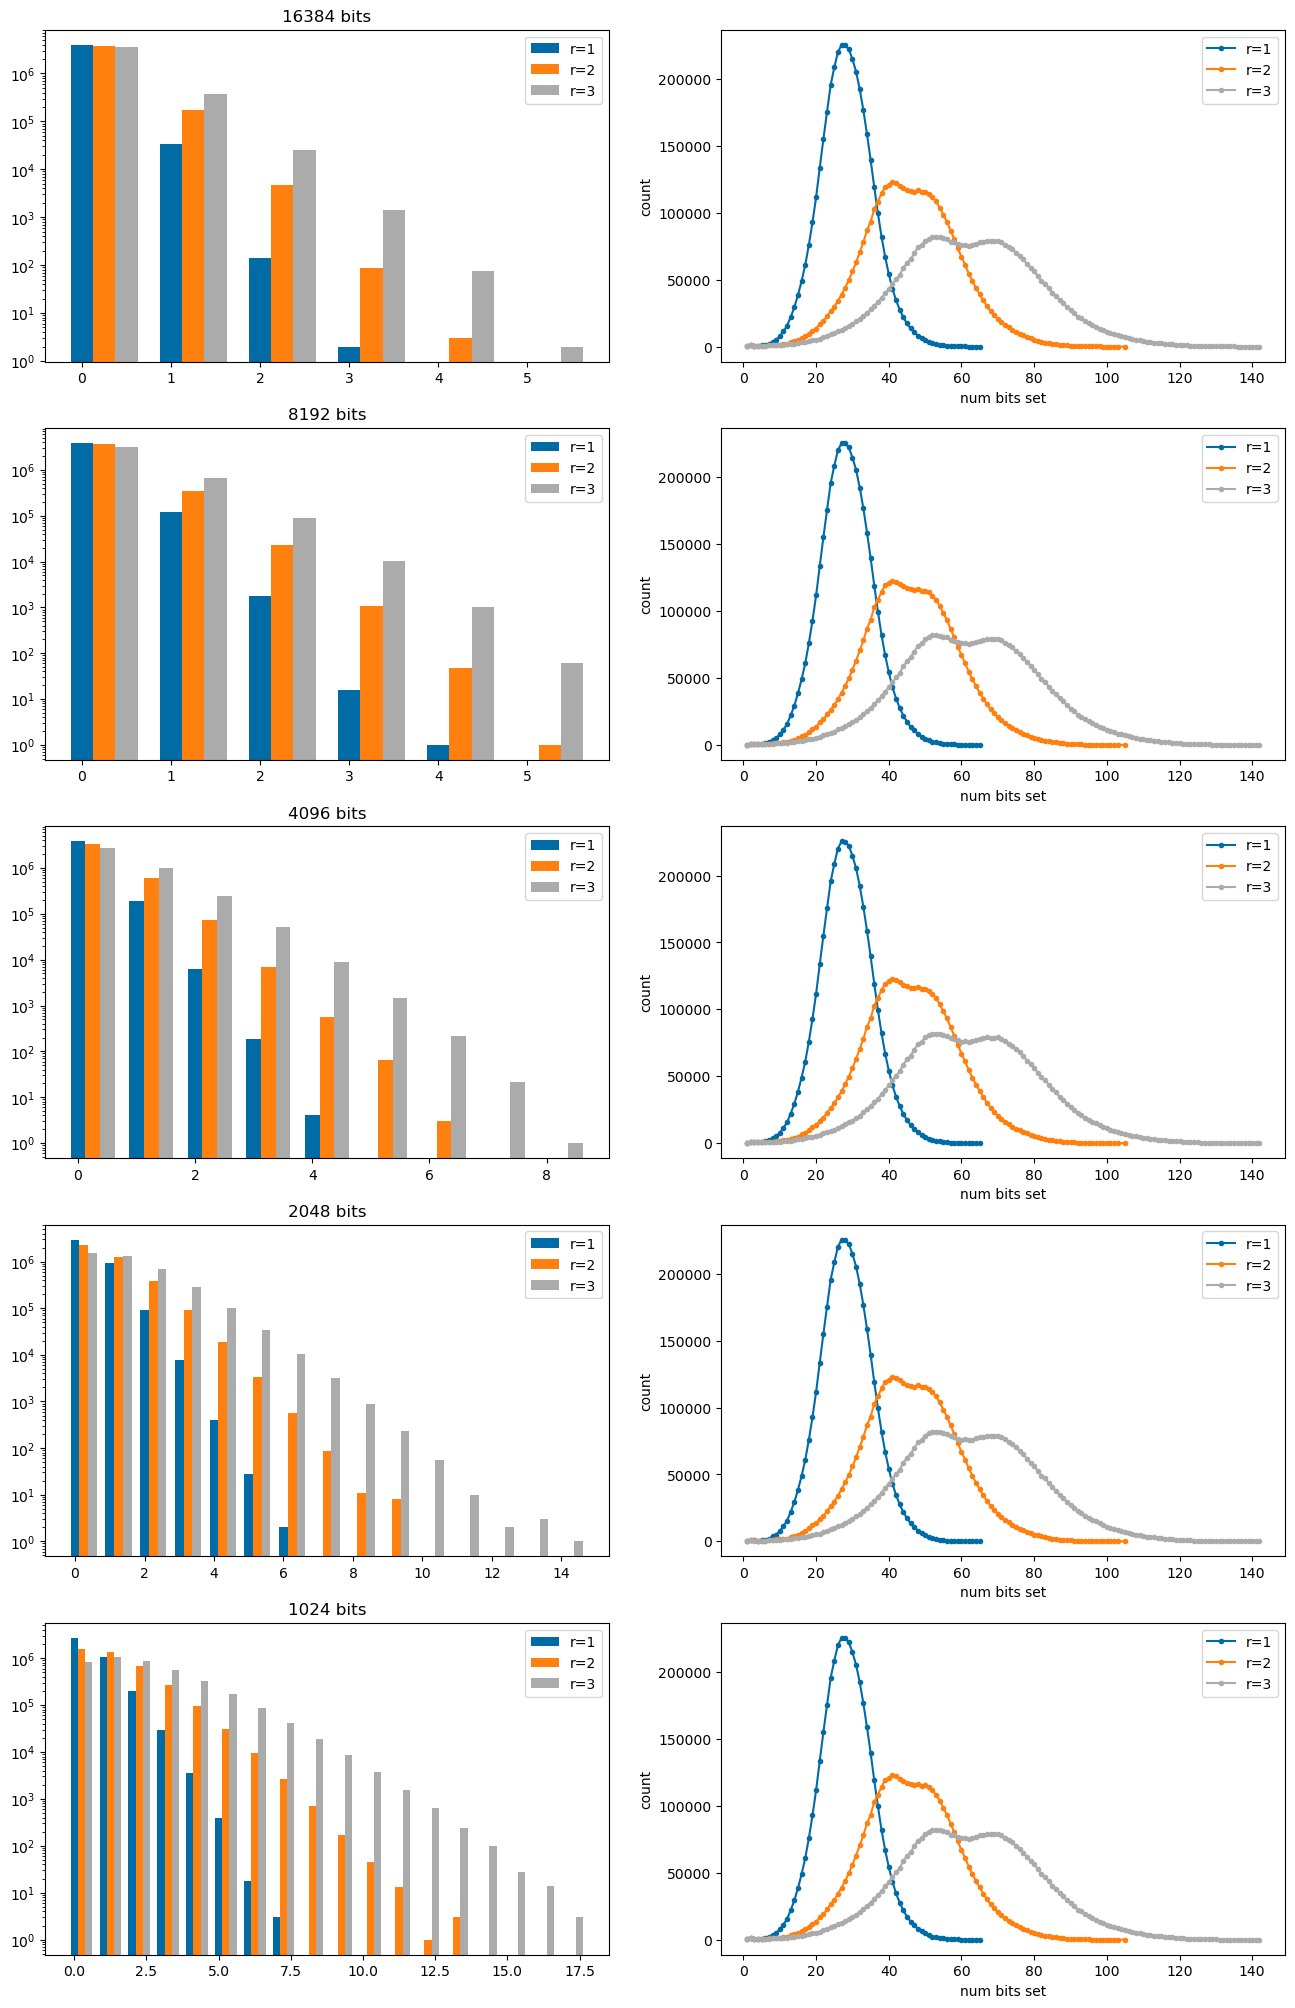

In [97]:
figure(figsize=(16,25))

pidx=1
#----------------------------
for nbits in (16384, 8192,4096,2048,1024):
    subplot(5,2,pidx)
    pidx+=1
    maxCollisions = max(counts[3,nbits].keys())+1
    d1=np.zeros(maxCollisions,int)
    for k,v in counts[1,nbits].items():
        d1[k]=v
    d2=np.zeros(maxCollisions,int)
    for k,v in counts[2,nbits].items():
        d2[k]=v
    d3=np.zeros(maxCollisions,int)
    for k,v in counts[3,nbits].items():
        d3[k]=v
    barWidth=.25
    locs = np.array(range(maxCollisions))

    bar(locs,d1,barWidth,label="r=1")
    bar(locs+barWidth,d2,barWidth,label="r=2")
    bar(locs+2*barWidth,d3,barWidth,label="r=3")
    
    #_=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=yscale("log")
    _=legend()

    subplot(5,2,pidx)
    pidx+=1
    itms = list(sorted(counts[1,-1].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=1")
    itms = list(sorted(counts[2,-1].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=2")
    itms = list(sorted(counts[3,-1].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=3")
    _=xlabel("num bits set")
    _=ylabel("count")
    _=legend()
    
    

So, there are definitely some collisions. But not a huge number.

Look at the shorter fingerprints

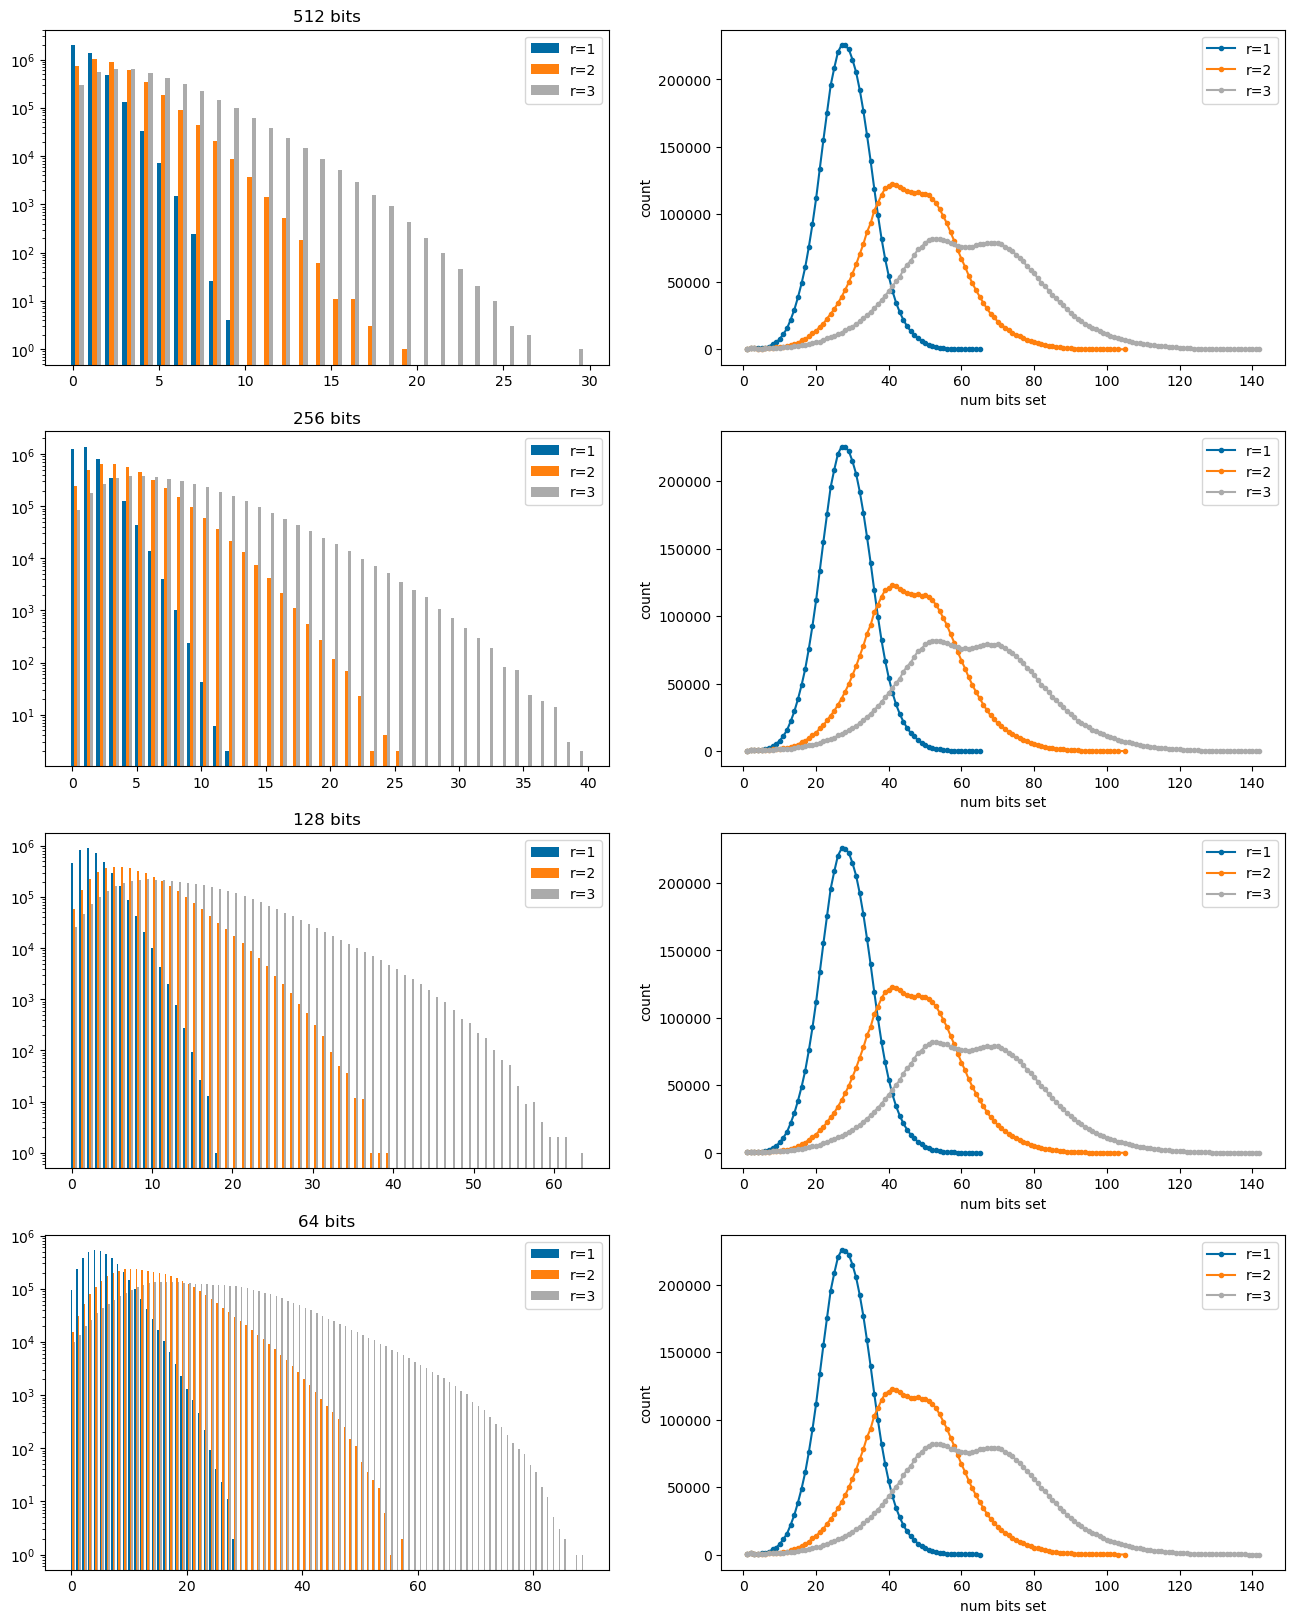

In [98]:
bcounts = (512,256,128,64)
figure(figsize=(16,5*len(bcounts)))

pidx=1
#----------------------------
for nbits in bcounts:
    subplot(len(bcounts),2,pidx)
    pidx+=1
    maxCollisions = max(counts[3,nbits].keys())+1
    d1=np.zeros(maxCollisions,int)
    for k,v in counts[1,nbits].items():
        d1[k]=v
    d2=np.zeros(maxCollisions,int)
    for k,v in counts[2,nbits].items():
        d2[k]=v
    d3=np.zeros(maxCollisions,int)
    for k,v in counts[3,nbits].items():
        d3[k]=v
    barWidth=.25
    locs = np.array(range(maxCollisions))

    bar(locs,d1,barWidth,label="r=1")
    bar(locs+barWidth,d2,barWidth,label="r=2")
    bar(locs+2*barWidth,d3,barWidth,label="r=3")
    
    #_=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=yscale("log")
    _=legend()

    subplot(len(bcounts),2,pidx)
    pidx+=1
    itms = list(sorted(counts[1,-1].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=1")
    itms = list(sorted(counts[2,-1].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=2")
    itms = list(sorted(counts[3,-1].items()))
    plot([x for x,y in itms],[y for x,y in itms],'.-',label=
        "r=3")
    _=xlabel("num bits set")
    _=ylabel("count")
    _=legend()
    
    

Look at that quantitatively

In [103]:
rads = (1,2,3)
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
ccounts = list(range(11))


row = ('length','radius',)+tuple(str(x) for x in ccounts)
divider = ['-'*len(k) for k in row]
print('| '+' | '.join(row)+' |')
print('| '+' | '.join(divider)+' |')

for bc in reversed(bcounts):
    for rad in rads:
        row = [str(bc),str(rad)]
        nmols = np.sum(np.fromiter((x for x in counts[rad,bc].values()),int))
        accum = 0
        for ccount in ccounts:
            accum += counts[rad,bc].get(ccount,0)
            row.append(f'{accum/nmols:.3f}')
        print('| '+' | '.join(row)+' |')
            

| length | radius | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| ------ | ------ | - | - | - | - | - | - | - | - | - | - | -- |
| 16384 | 1 | 0.991 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 16384 | 2 | 0.956 | 0.999 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 16384 | 3 | 0.900 | 0.993 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 8192 | 1 | 0.969 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 8192 | 2 | 0.906 | 0.994 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 8192 | 3 | 0.808 | 0.974 | 0.997 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 4096 | 1 | 0.950 | 0.998 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 4096 | 2 | 0.829 | 0.980 | 0.998 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 | 1.000 |
| 4096 | 3 | 0.673 | 0.922 | 0.985 | 0.997 | 1.000 | 1.000 

# Impact on similarity

In [31]:
pairs = []
for l in gzip.open('../data/chembl21_25K.mfp1.pairs.txt.gz','rt'):
    l = l.split()
    pairs.append([Chem.MolFromSmiles(l[1]),Chem.MolFromSmiles(l[3])])

In [55]:
sims = defaultdict(list)
for v in 1,2,3:
    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=v)
    for m1,m2 in pairs:
        fp1 = fpg.GetSparseFingerprint(m1)
        fp2 = fpg.GetSparseFingerprint(m2)
        sims[(v,-1)].append(DataStructs.TanimotoSimilarity(fp1,fp2))
    for l in 64,128,256,512,1024,2048,4096,8192,16384:
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=v,fpSize=l)
        for m1,m2 in pairs:
            fp1 = fpg.GetFingerprint(m1)
            fp2 = fpg.GetFingerprint(m2)
            sims[(v,l)].append(DataStructs.TanimotoSimilarity(fp1,fp2))


In [56]:
pickle.dump(dict(sims),gzip.open('../data/fp_collision_sims.pkl.gz','wb+'))

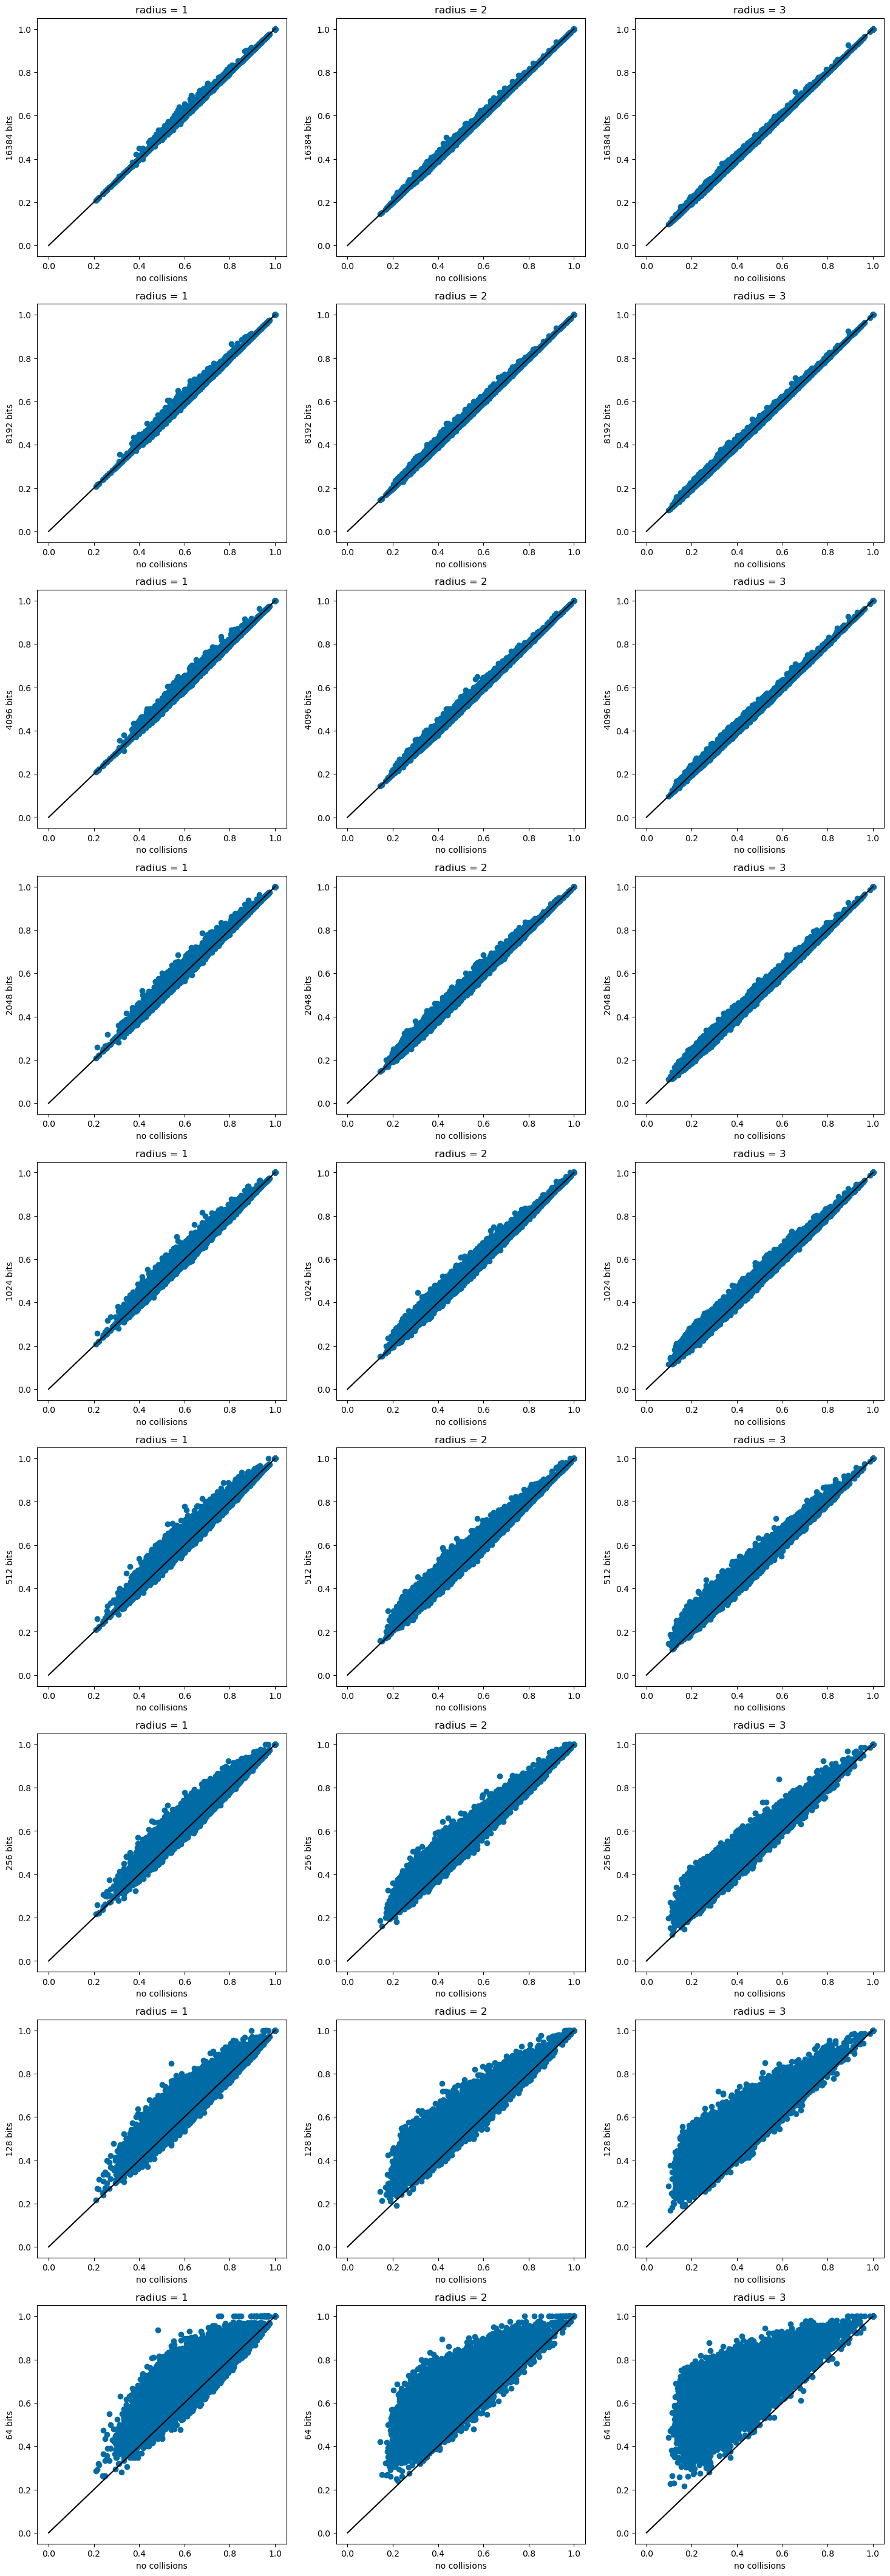

In [66]:
rads = (1,2,3)
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
figsize(3*6,len(bcounts)*6)

plt = 1
for i,cnt in enumerate(reversed(bcounts)):
    for j,rad in enumerate(rads):
        subplot(len(bcounts),3,plt)
        plt += 1
        scatter(sims[rad,-1],sims[rad,cnt])
        plot((0,1),(0,1),'k-')
        xlabel('no collisions')
        ylabel(f'{cnt} bits')
        title(f'radius = {rad}')

In [67]:
from scipy.stats import spearmanr

row = ('radius','length','SpearmanR','mean(d)','std(d)','90% |d|')
divider = ['-'*len(k) for k in row]
print('| '+' | '.join(row)+' |')
print('| '+' | '.join(divider)+' |')
        

rads = (1,2,3)
bcounts = (64,128,256,512,1024,2048,4096,8192,16384)
for i,cnt in enumerate(reversed(bcounts)):
    for j,rad in enumerate(rads):
        d1 = numpy.array(sims[rad,-1])
        d2 = numpy.array(sims[rad,cnt])
        delt = d2-d1
        row = [str(cnt),str(rad),f'{spearmanr(d1,d2).correlation:.3f}',f'{np.mean(delt):.2g}',
               f'{np.std(delt):.2g}',f'{np.quantile(np.abs(delt),0.9):.2g}']
        print('| '+' | '.join(row)+' |')

| radius | length | SpearmanR | mean(d) | std(d) | 90% |d| |
| ------ | ------ | --------- | ------- | ------ | ------- |
| 16384 | 1 | 1.000 | 0.0002 | 0.0025 | 0 |
| 16384 | 2 | 1.000 | 0.00074 | 0.0037 | 0 |
| 16384 | 3 | 1.000 | 0.0012 | 0.0038 | 0.0053 |
| 8192 | 1 | 0.999 | 0.00071 | 0.0048 | 0 |
| 8192 | 2 | 0.999 | 0.0014 | 0.0051 | 0.0068 |
| 8192 | 3 | 0.999 | 0.0024 | 0.0054 | 0.011 |
| 4096 | 1 | 0.998 | 0.0014 | 0.0067 | 0 |
| 4096 | 2 | 0.998 | 0.0028 | 0.0072 | 0.012 |
| 4096 | 3 | 0.998 | 0.0047 | 0.0076 | 0.016 |
| 2048 | 1 | 0.993 | 0.0035 | 0.012 | 0.019 |
| 2048 | 2 | 0.996 | 0.0059 | 0.012 | 0.023 |
| 2048 | 3 | 0.996 | 0.0093 | 0.012 | 0.025 |
| 1024 | 1 | 0.989 | 0.0056 | 0.015 | 0.025 |
| 1024 | 2 | 0.992 | 0.012 | 0.016 | 0.033 |
| 1024 | 3 | 0.991 | 0.019 | 0.017 | 0.041 |
| 512 | 1 | 0.981 | 0.011 | 0.021 | 0.04 |
| 512 | 2 | 0.983 | 0.024 | 0.023 | 0.055 |
| 512 | 3 | 0.981 | 0.039 | 0.025 | 0.071 |
| 256 | 1 | 0.964 | 0.022 | 0.028 | 0.06 |
| 256 | 2 | 0.96